In [446]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ
from qiskit.visualization import plot_histogram, plot_bloch_multivector, circuit_drawer, plot_state_city, plot_state_hinton

from qiskit.providers.ibmq import least_busy
from qiskit.compiler import transpile, assemble
from qiskit.tools.monitor import job_monitor

import matplotlib.pyplot as plt
import numpy as np



# Functions

In [410]:
def half_adder_gate():
    q = QuantumRegister(3, 'q')
    qc = QuantumCircuit(q)

    # Add the AND gate
    qc.ccx(q[0], q[1], q[2])
    
    # Add the XOR gate
    qc.cx(q[0], q[1])
    
    
    display(qc.draw(output='mpl'))
    print('👆 this is the half adder circuit.')
    
    ha_gate = qc.to_gate()
    ha_gate.name = 'Half-Adder'
    return ha_gate

def test_half_adder_gate(a, b, half_adder_gate):
    q = QuantumRegister(3, 'q')
    c = ClassicalRegister(2, 'c')
    qc = QuantumCircuit(q, c)
    
    qc.x(q[0]) if a==1 else _
    qc.x(q[1]) if b==1 else _
    
    qc.append(half_adder_gate, range(3))
    qc.measure(q[1:], c)
    
    return qc

In [415]:
def full_adder_gate():
    q = QuantumRegister(4, 'q')
    qc = QuantumCircuit(q)

    qc.ccx(q[0], q[1], q[3])
    qc.cx(q[0], q[1])
    
    qc.ccx(q[1], q[2], q[3])
    qc.cx(q[1], q[2])
    
    qc.cx(q[0], q[1])
    
    
    display(qc.draw(output='mpl'))
    print('👆 this is the full adder circuit.')
    
    ha_gate = qc.to_gate()
    ha_gate.name = 'Full-Adder'
    return ha_gate

def test_full_adder_gate(a, b, cin, full_adder_gate, ah=False, bh=False):
    # ah = a hadamard , bh = b hadamard
    q = QuantumRegister(4, 'q')
    c = ClassicalRegister(2, 'c')
    qc = QuantumCircuit(q, c)
    
    qc.x(q[0]) if a==1 else _
    qc.x(q[1]) if b==1 else _
    qc.x(q[2]) if cin==1 else _
    
    qc.h(q[0]) if ah else _
    qc.h(q[1]) if bh else _
    
    qc.append(full_adder_gate, range(4))
    qc.measure(q[2:], c)
    
    return qc

In [640]:
def S_gate():
    q = QuantumRegister(3, 'q')
    qc = QuantumCircuit(q)

    qc.cx(q[1], q[2])
    qc.cx(q[0], q[2])
    
    
    display(qc.draw(output='mpl'))
    print('👆 this is the quantum sum circuit. [Q-Sum]')
    
    _gate = qc.to_gate()
    _gate.name = 'Q-Sum'
    return _gate

def C_gate():
    q = QuantumRegister(4, 'q')
    qc = QuantumCircuit(q)

    qc.ccx(q[1], q[2], q[3])
    qc.cx(q[1], q[2])
    qc.ccx(q[0], q[2], q[3])
    
    
    display(qc.draw(output='mpl'))
    print('👆 this is the quantum carry circuit. [Q-Carry]')
    
    _gate = qc.to_gate()
    _gate.name = 'Q-Carry'
    return _gate

def test_ripple_carry_adder(a, b):
    if not isinstance(a, str) or not isinstance(b, str):
        raise ValueError("Inputs are not a string.")
    if not all(char in ['0', '1'] for char in a) or not all(char in ['0', '1'] for char in b):
        raise ValueError("Inputs contain non-binary characters.")
    if len(a) != len(b):
        raise ValueError("Inputs are not the same length.")
        
    c_gate = C_gate()
    s_gate = S_gate()
    
    len_q = (len(a)-1)*3 + 4
    len_c = len(a) + 1 
    q = QuantumRegister(len_q, 'q')
    c = ClassicalRegister(len_c, 'c')
    qc = QuantumCircuit(q, c)
    
    i_g = 0
    i_a = 1
    i_b = 2
    for i in range(len(a) - 1, -1, -1):
        qc.x(q[i_a]) if int(a[i])==1 else _
        qc.x(q[i_b]) if int(b[i])==1 else _
        qc.append(c_gate, range(i_g, i_g+4))
        i_g+=3
        i_a+=3
        i_b+=3
    
    qc.cx(q[len_q-3], q[len_q-2])  
    i_g-=3
    i_b-=3
    qc.append(s_gate, range(len_q-4, i_g+3))
    qc.measure(q[-1], c[0])
    qc.measure(q[-2], c[1])
    
    for i in range(2,len_c):
        i_g-=3
        i_b-=3
        qc.append(c_gate, range(i_g, i_g+4))
        qc.append(s_gate, range(i_g, i_g+3))
        qc.measure(q[i_b], c[i])
    
    return qc

In [483]:
def run_on_simulation(qc, shots=100):
#     simulator = Aer.get_backend('qasm_simulator')
    simulator = Aer.get_backend('statevector_simulator')
    job = execute(qc, simulator, shots=shots)

    return job.result()

def least_busy_backend(n_qubits):
    IBMQ.load_account()
    provider = IBMQ.get_provider(hub='ibm-q')
    backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (n_qubits+1) and
                                       not x.configuration().simulator and x.status().operational==True))
    print("least busy backend: ", backend)
    
    return backend


def run_on_IBMQ(qc, backend, shots=100):
    transpiled_qc = transpile(qc, backend, optimization_level=3)
    job = backend.run(transpiled_qc, shots=shots)
    job_monitor(job, interval=2)
    
    return job.result()


In [336]:
def binary_dict(n):
    dict_values = {}
    for i in range(2**n):
        binary = bin(i)[2:].zfill(n)
        dict_values[binary] = 0

    return dict_values

# Quantum Half-Adder
- this section answered on point 1 & 2.
- the backend was `ibm_manila`.

ibmqfactory.load_account:WARNING:2023-03-18 19:27:49,853: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmq_manila


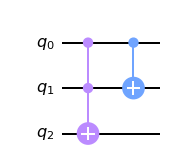

👆 this is the half adder circuit.

--------------------
input {'00': 100}
Job Status: job has successfully run
output {'00': 100} [simulation]
output {'00': 89, '01': 5, '10': 3, '11': 3} [IBMQ]


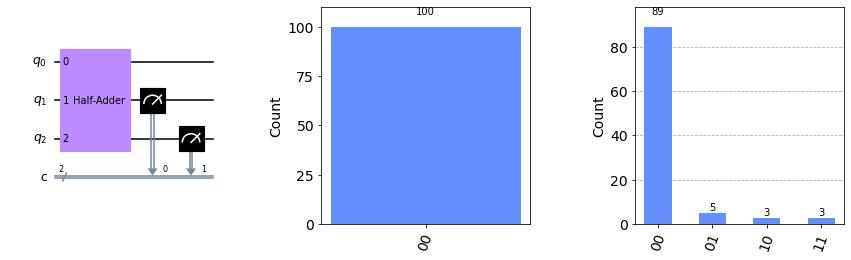


--------------------
input {'01': 100}
Job Status: job has successfully run
output {'01': 100} [simulation]
output {'00': 9, '01': 86, '10': 1, '11': 4} [IBMQ]


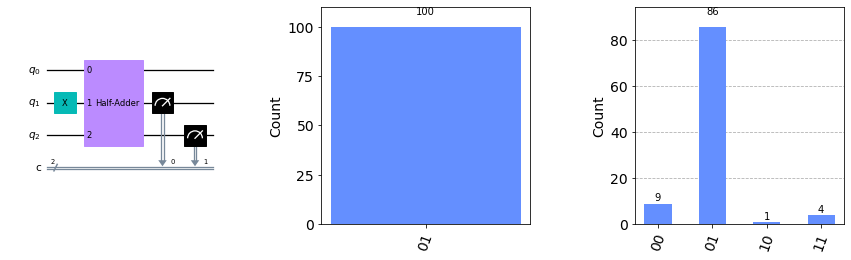


--------------------
input {'10': 100}
Job Status: job has successfully run
output {'01': 100} [simulation]
output {'00': 8, '01': 78, '10': 8, '11': 6} [IBMQ]


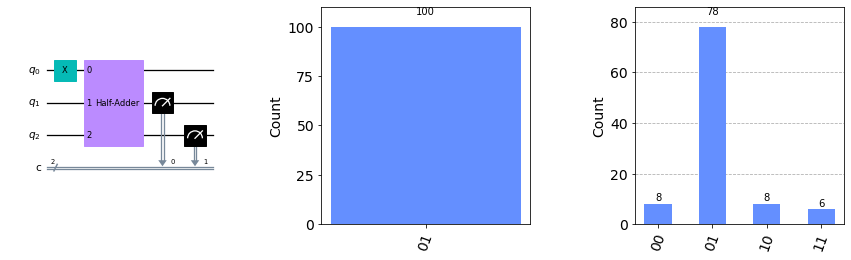


--------------------
input {'11': 100}
Job Status: job has successfully run
output {'10': 100} [simulation]
output {'00': 5, '01': 7, '10': 76, '11': 12} [IBMQ]


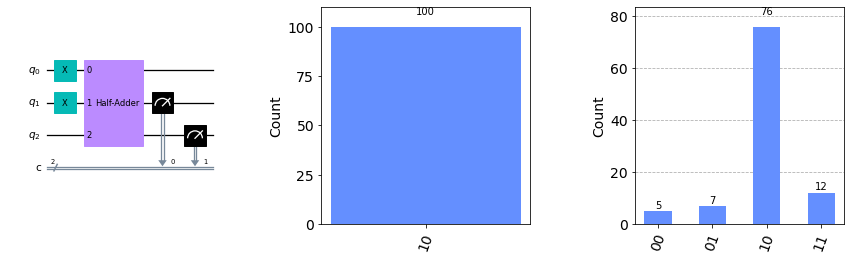

In [135]:
backend = least_busy_backend(3)

gate = half_adder_gate()

for a in range(2):
    for b in range(2):
        print(f"\n{'-'*20}")
        print('input', f"{{'{a}{b}': {shots}}}")
        
        qc = test_half_adder_gate(a, b, gate)
        counts_sim = run_on_simulation(qc)
        counts_ibmq = run_on_IBMQ(qc, backend)
        
        print('output', counts_sim, '[simulation]')
        print('output', counts_ibmq, '[IBMQ]')
        
        fig, axs = plt.subplots(1, 3, figsize=(15, 4))
        fig.subplots_adjust(wspace=0.5)
        circuit_drawer(qc, ax=axs[0], output='mpl')
        plot_histogram(counts_sim, ax=axs[1])
        plot_histogram(counts_ibmq, ax=axs[2])
        plt.show()
        

ibmqfactory.load_account:WARNING:2023-03-26 23:53:19,199: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmq_quito


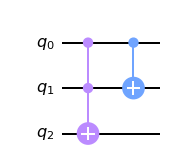

👆 this is the half adder circuit.

--------------------
input a=0, b=0
Job Status: job is queued (18)    

KeyboardInterrupt: 

In [637]:
backend = least_busy_backend(3)

gate = half_adder_gate()

for a in range(2):
    for b in range(2):
        print(f"\n{'-'*20}")
        print('input', f"a={a}, b={b}")
        
        qc = test_half_adder_gate(a, b, gate)
        counts_sim = run_on_simulation(qc)
        counts_ibmq = run_on_IBMQ(qc, backend)
        
        print('output', counts_sim, '[simulation]')
        print('output', counts_ibmq, '[IBMQ]')
        

        fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15, 4))
        gs = axs[1, 2].get_gridspec()
        # remove the underlying axes
        for ax in axs[0:, 0]:
            ax.remove()
        axbig1 = fig.add_subplot(gs[0:, 0])

        for ax in axs[1, 1:]:
            ax.remove()
        axbig2 = fig.add_subplot(gs[1, 1:])

        circuit_drawer(qc, ax=axbig1, output='mpl')

        # measurement of simulation
        _dict = counts_sim.get_counts()
        _counts = {**binary_dict(len(next(iter(_dict)))), **_dict}
        plot_histogram(_counts, ax=axs[0,1], title='Probabilities [Simulation]')

        # measurement of real machine
        _dict = counts_ibmq.get_counts()
        _counts = {**binary_dict(len(next(iter(_dict)))), **_dict}
        plot_histogram(_counts, ax=axs[0,2], title='Probabilities [IBMQ]')

        # statevectors of simulation
        _dict = counts_sim.get_statevector().to_dict()
        _counts = {**binary_dict(len(next(iter(_dict)))), **_dict}
        plot_histogram(_counts, ax=axbig2, title='Statevector')

        fig.tight_layout()

        plt.show()
        

> the above code will show statevector. but due to the queue, the `github` will be updated once completed.

# Quantum Full-Adder
- this section answered on point 3, 4, & 5.
- due to `ibmq_manila` is so busy, I used another backend.

ibmqfactory.load_account:WARNING:2023-03-26 02:23:28,948: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmq_quito


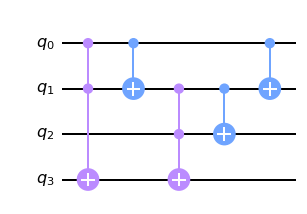

👆 this is the full adder circuit.

--------------------
input {'000': 100}
Job Status: job has successfully run
output {'00': 100} [simulation]
output {'00': 78, '01': 9, '10': 11, '11': 2} [IBMQ]


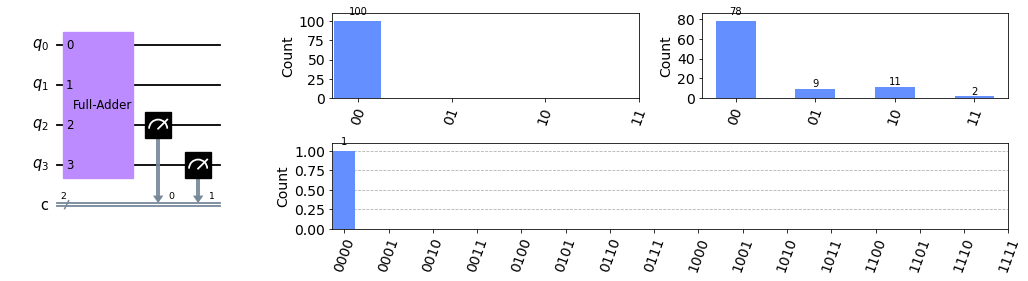


--------------------
input {'001': 100}
Job Status: job has successfully run
output {'01': 100} [simulation]
output {'00': 15, '01': 72, '10': 9, '11': 4} [IBMQ]


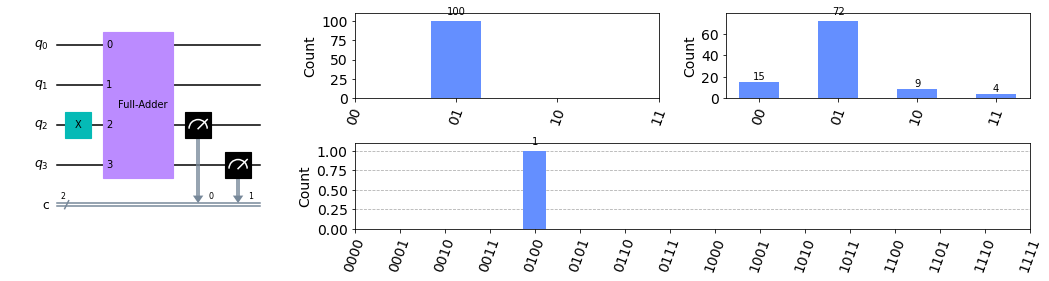


--------------------
input {'010': 100}
Job Status: job has successfully run
output {'01': 100} [simulation]
output {'00': 16, '01': 70, '10': 7, '11': 7} [IBMQ]


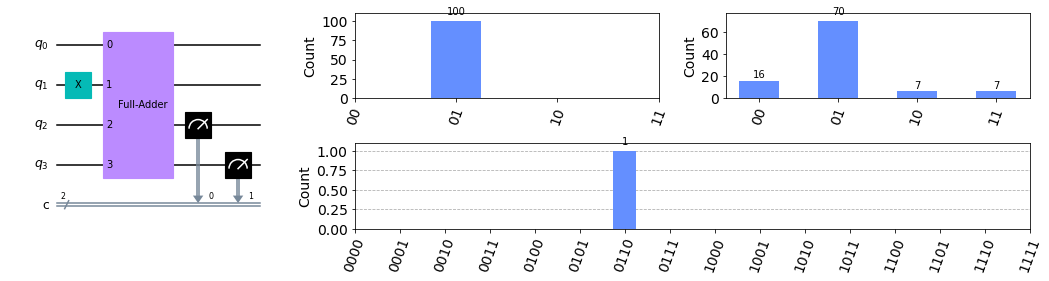


--------------------
input {'011': 100}
Job Status: job has successfully run
output {'10': 100} [simulation]
output {'00': 9, '01': 17, '10': 69, '11': 5} [IBMQ]


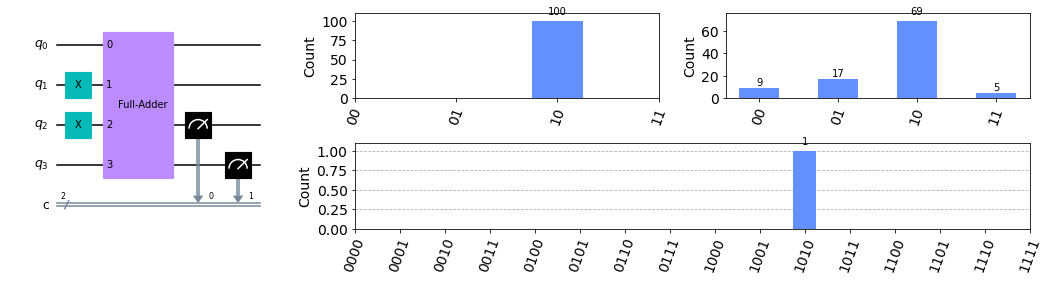


--------------------
input {'100': 100}
Job Status: job has successfully run
output {'01': 100} [simulation]
output {'00': 18, '01': 70, '10': 8, '11': 4} [IBMQ]


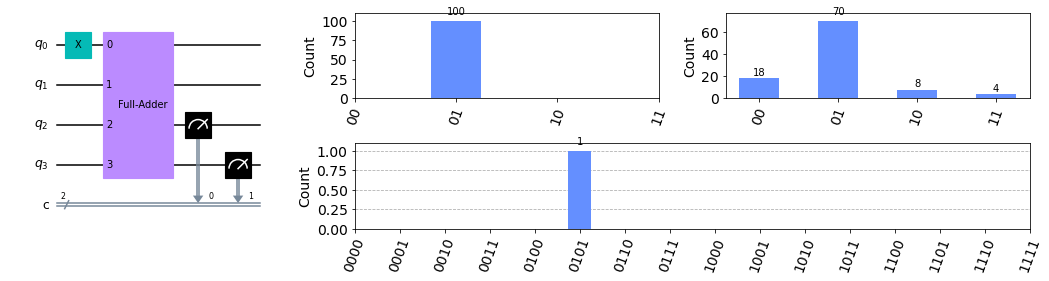


--------------------
input {'101': 100}
Job Status: job has successfully run
output {'10': 100} [simulation]
output {'00': 11, '01': 13, '10': 66, '11': 10} [IBMQ]


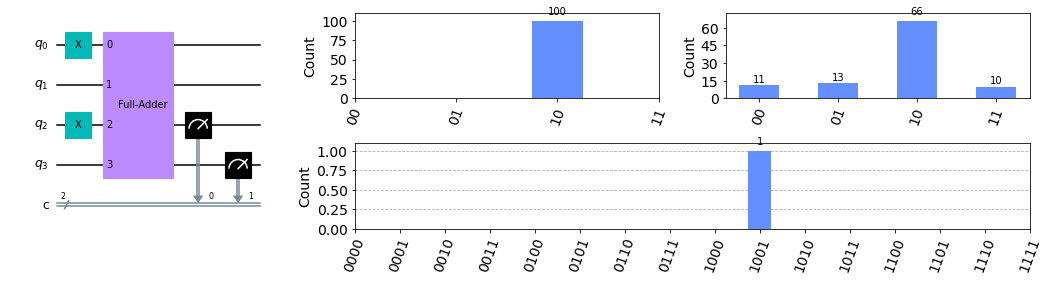


--------------------
input {'110': 100}
Job Status: job has successfully run
output {'10': 100} [simulation]
output {'00': 9, '01': 6, '10': 76, '11': 9} [IBMQ]


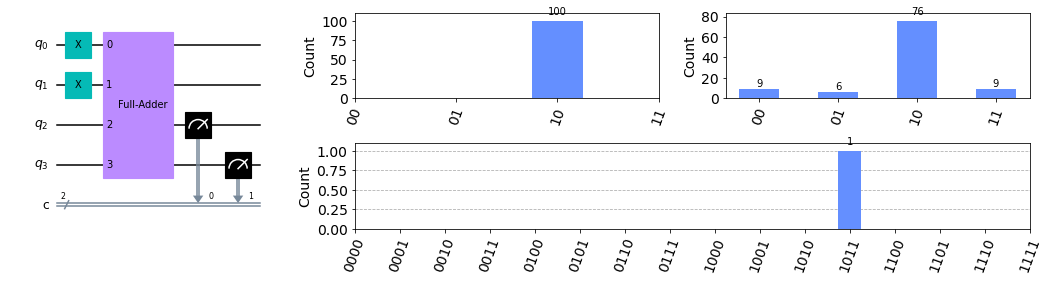


--------------------
input {'111': 100}
Job Status: job has successfully run
output {'11': 100} [simulation]
output {'00': 13, '01': 6, '10': 16, '11': 65} [IBMQ]


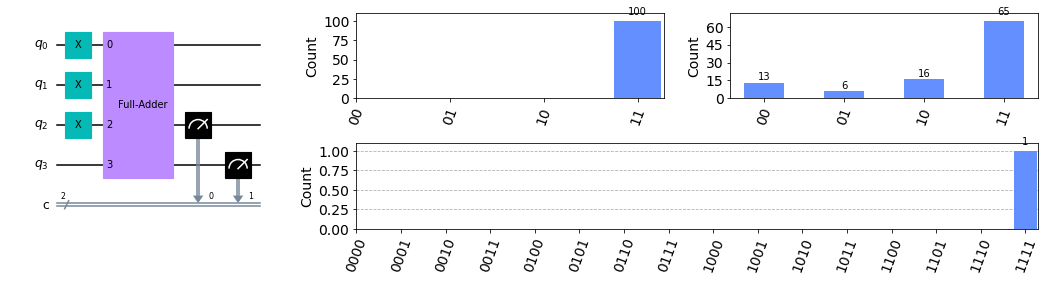

In [407]:
backend = least_busy_backend(4)
# backend = provider.get_backend('ibmq_manila')


gate = full_adder_gate()

for a in range(2):
    for b in range(2):
        for cin in range(2):
            print(f"\n{'-'*20}")
            print('input', f"{{'{a}{b}{cin}': {shots}}}")

            qc = test_full_adder_gate(a, b, cin, gate)
            counts_sim = run_on_simulation(qc)
            counts_ibmq = run_on_IBMQ(qc, backend)

            print('output', counts_sim.get_counts(), '[simulation]')
            print('output', counts_ibmq.get_counts(), '[IBMQ]')

    
            fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15, 4))
            gs = axs[1, 2].get_gridspec()
            # remove the underlying axes
            for ax in axs[0:, 0]:
                ax.remove()
            axbig1 = fig.add_subplot(gs[0:, 0])
            
            for ax in axs[1, 1:]:
                ax.remove()
            axbig2 = fig.add_subplot(gs[1, 1:])
            
            circuit_drawer(qc, ax=axbig1, output='mpl')
            
            # measurement of simulation
            _dict = counts_sim.get_counts()
            _counts = {**binary_dict(len(next(iter(_dict)))), **_dict}
            plot_histogram(_counts, ax=axs[0,1])
            
            # measurement of real machine
            _dict = counts_ibmq.get_counts()
            _counts = {**binary_dict(len(next(iter(_dict)))), **_dict}
            plot_histogram(_counts, ax=axs[0,2])
            
            # statevectors of simulation
            _dict = counts_sim.get_statevector().to_dict()
            _counts = {**binary_dict(len(next(iter(_dict)))), **_dict}
            plot_histogram(_counts, ax=axbig2)
            
            fig.tight_layout()

            plt.show()
        

ibmqfactory.load_account:WARNING:2023-03-26 19:48:34,254: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibm_nairobi


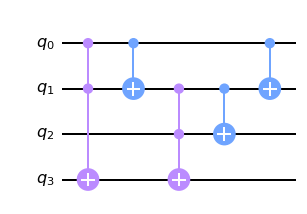

👆 this is the full adder circuit.

--------------------
input a=0, b=0, cin=0
Job Status: job has successfully run
output {'01': 52, '00': 48} [simulation]
output {'00': 29, '01': 49, '10': 16, '11': 6} [IBMQ]


/opt/anaconda3/lib/python3.8/site-packages/qiskit/visualization/counts_visualization.py:478: ComplexWarning: Casting complex values to real discards the imaginary part
  pvalues = np.array(values, dtype=int)


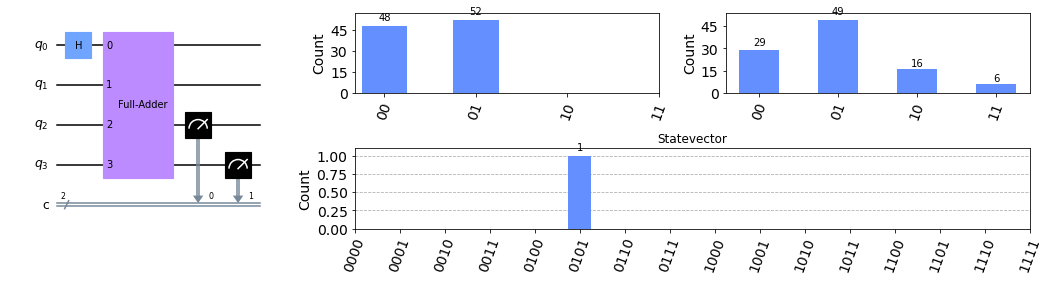


--------------------
input a=0, b=0, cin=1
Job Status: job has successfully run
output {'01': 49, '10': 51} [simulation]
output {'00': 5, '01': 33, '10': 48, '11': 14} [IBMQ]


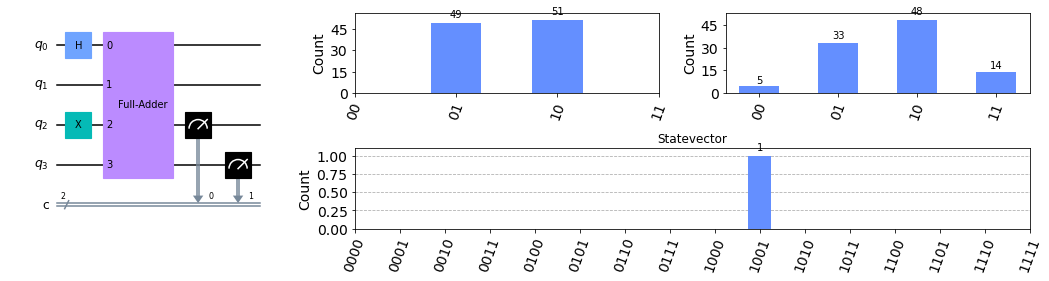


--------------------
input a=0, b=1, cin=0
Job Status: job has successfully run
output {'01': 52, '10': 48} [simulation]
output {'00': 8, '01': 46, '10': 36, '11': 10} [IBMQ]


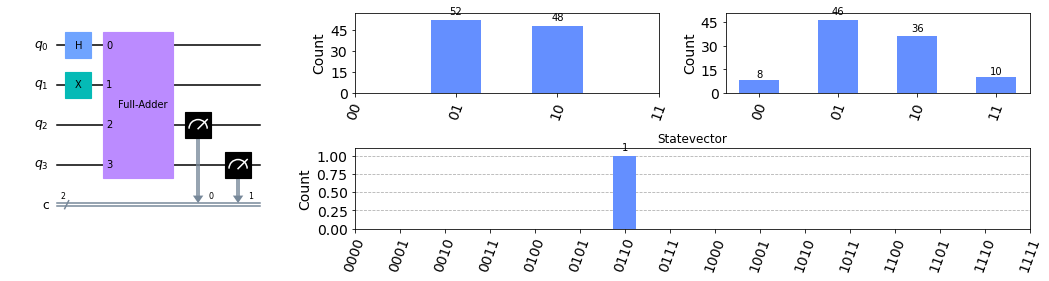


--------------------
input a=0, b=1, cin=1
Job Status: job has successfully run
output {'11': 48, '10': 52} [simulation]
output {'00': 4, '01': 21, '10': 39, '11': 36} [IBMQ]


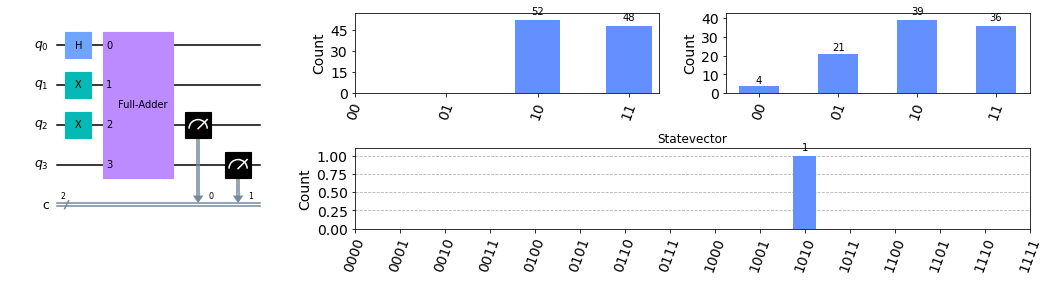


--------------------
input a=1, b=0, cin=0
Job Status: job has successfully run
output {'01': 48, '00': 52} [simulation]
output {'00': 50, '01': 35, '10': 11, '11': 4} [IBMQ]


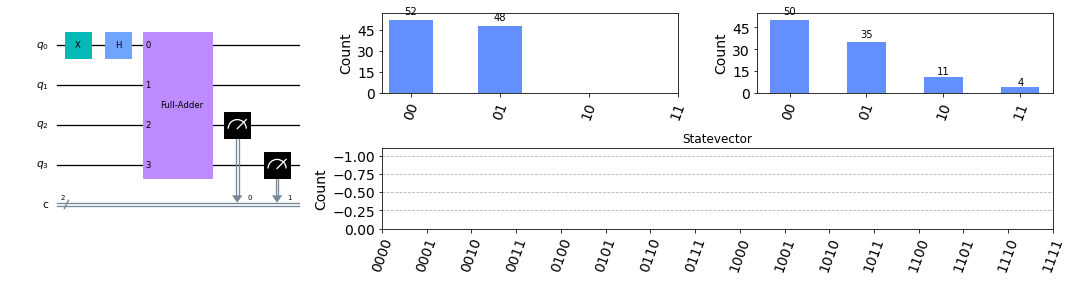


--------------------
input a=1, b=0, cin=1
Job Status: job has successfully run
output {'01': 44, '10': 56} [simulation]
output {'00': 12, '01': 37, '10': 42, '11': 9} [IBMQ]


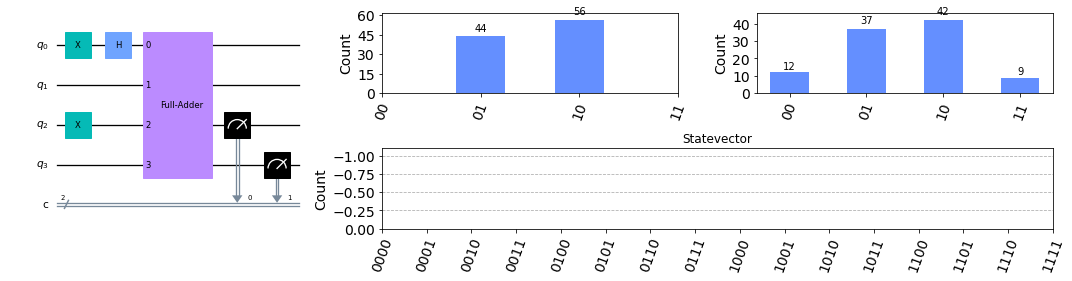


--------------------
input a=1, b=1, cin=0
Job Status: job has successfully run
output {'10': 54, '01': 46} [simulation]
output {'00': 12, '01': 43, '10': 40, '11': 5} [IBMQ]


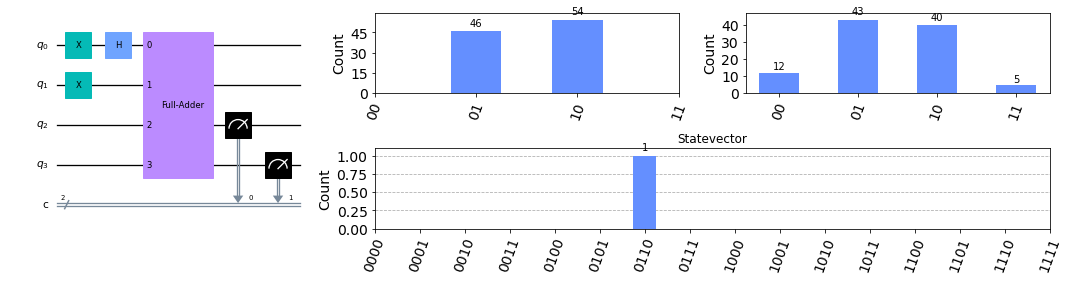


--------------------
input a=1, b=1, cin=1
Job Status: job has successfully run
output {'10': 48, '11': 52} [simulation]
output {'00': 9, '01': 11, '10': 45, '11': 35} [IBMQ]


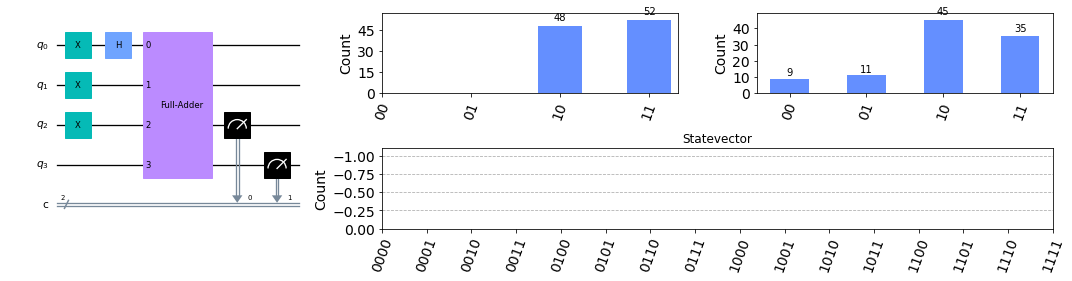

In [422]:
backend = least_busy_backend(4)
# backend = provider.get_backend('ibmq_manila')


gate = full_adder_gate()

for a in range(2):
    for b in range(2):
        for cin in range(2):
            print(f"\n{'-'*20}")
            print('input', f"a={a}, b={b}, cin={cin}")

            qc = test_full_adder_gate(a, b, cin, gate, ah=True)
            counts_sim = run_on_simulation(qc)
            counts_ibmq = run_on_IBMQ(qc, backend)

            print('output', counts_sim.get_counts(), '[simulation]')
            print('output', counts_ibmq.get_counts(), '[IBMQ]')

    
            fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15, 4))
            gs = axs[1, 2].get_gridspec()
            # remove the underlying axes
            for ax in axs[0:, 0]:
                ax.remove()
            axbig1 = fig.add_subplot(gs[0:, 0])
            
            for ax in axs[1, 1:]:
                ax.remove()
            axbig2 = fig.add_subplot(gs[1, 1:])
            
            circuit_drawer(qc, ax=axbig1, output='mpl')
            
            # measurement of simulation
            _dict = counts_sim.get_counts()
            _counts = {**binary_dict(len(next(iter(_dict)))), **_dict}
            plot_histogram(_counts, ax=axs[0,1], title='Probabilities [Simulation]')
            
            # measurement of real machine
            _dict = counts_ibmq.get_counts()
            _counts = {**binary_dict(len(next(iter(_dict)))), **_dict}
            plot_histogram(_counts, ax=axs[0,2], title='Probabilities [IBMQ]')
            
            # statevectors of simulation
            _dict = counts_sim.get_statevector().to_dict()
            _counts = {**binary_dict(len(next(iter(_dict)))), **_dict}
            plot_histogram(_counts, ax=axbig2, title='Statevector')
            
            fig.tight_layout()

            plt.show()
        

> Note: The empty graphs of the statevector are in fact negative values, not empty.

# Quantum Ripple-Carry Adder
- this section answer on point 6 & 7.
- Ripple-Carry Adder function is scalable.

A=101 B=100


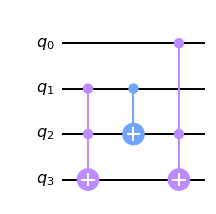

👆 this is the quantum carry circuit. [Q-Carry]


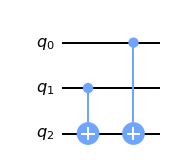

👆 this is the quantum sum circuit. [Q-Sum]

--------------------
output {'1001': 100} [simulation]


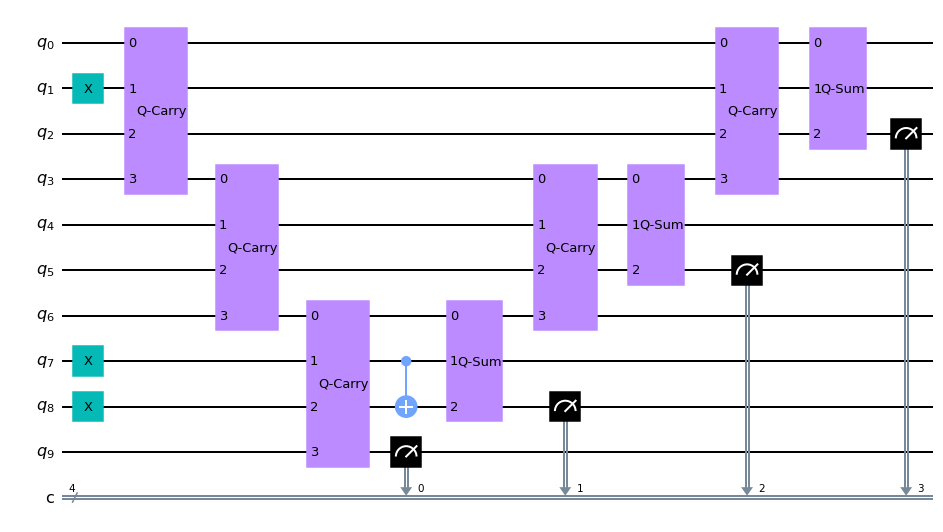

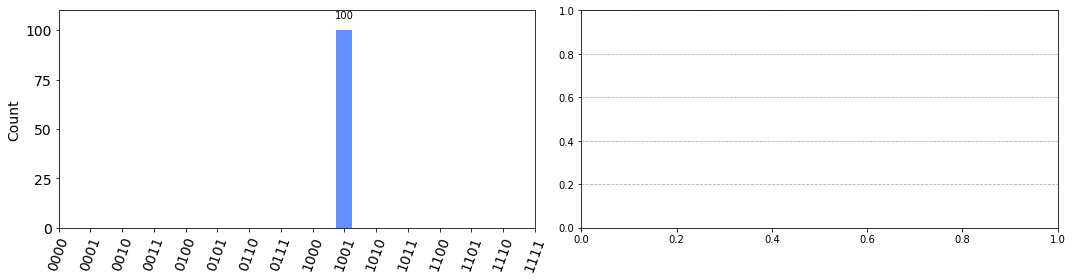

In [644]:
# 200319350
A = str(bin((5+0)%8)[2:])
B = str(bin((9+3)%8)[2:])

# backend = least_busy_backend(10)
# backend = provider.get_backend('ibmq_manila')

print(f'A={A}',f'B={B}')
qc = test_ripple_carry_adder(A, B)

counts_sim = run_on_simulation(qc)
# counts_ibmq = run_on_IBMQ(qc, backend)

print(f"\n{'-'*20}")

print('output', counts_sim.get_counts(), '[simulation]')
# print('output', counts_ibmq.get_counts(), '[IBMQ]')



fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(15, 4))

display(circuit_drawer(qc, output='mpl'))

# measurement of simulation
_dict = counts_sim.get_counts()
_counts = {**binary_dict(len(next(iter(_dict)))), **_dict}
plot_histogram(_counts, ax=axs[0])

# # measurement of real machine
# _dict = counts_ibmq.get_counts()
# _counts = {**binary_dict(len(next(iter(_dict)))), **_dict}
# plot_histogram(_counts, ax=axs[1])



fig.tight_layout()

plt.show()
        

> Due to unable to find the least busy backend from an empty list that has 10 qubits. Therefore, I have used  simulator only. Once there will be available a proper backend, I will update `github` the result.

## Ripple-Carry Adder Function is Scalable

A=1000 B=1101


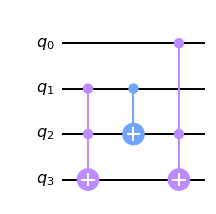

👆 this is the quantum carry circuit. [Q-Carry]


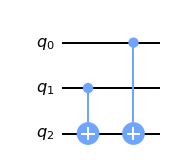

👆 this is the quantum sum circuit. [Q-Sum]

--------------------
output {'10101': 100} [simulation]


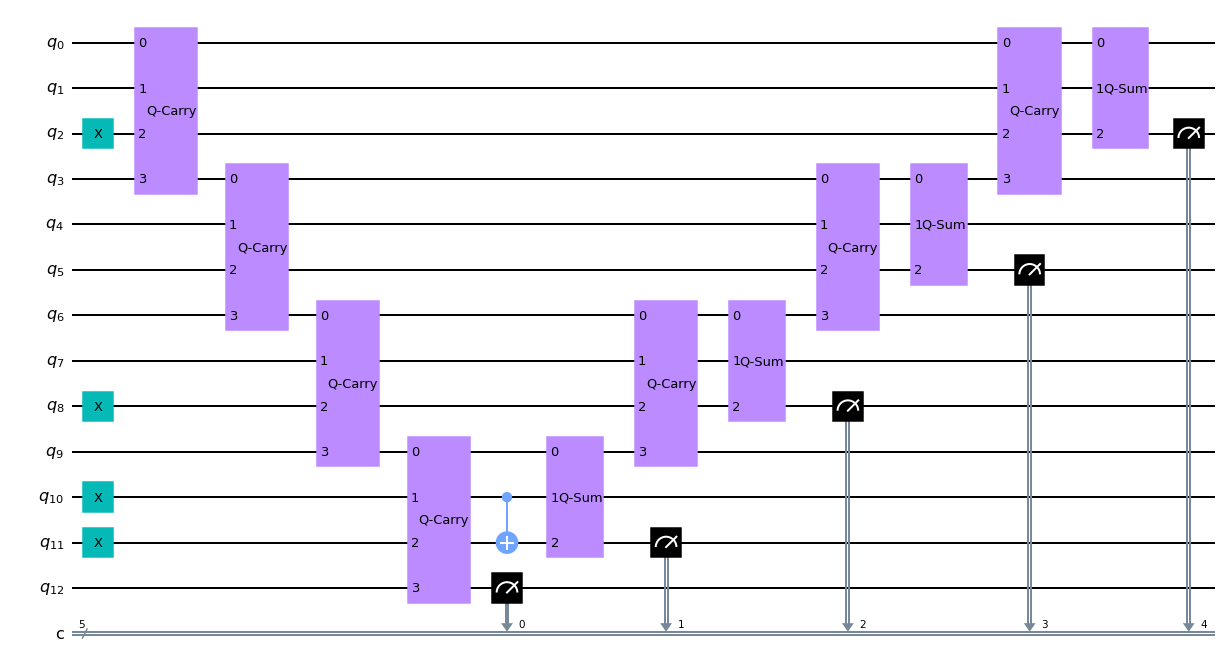

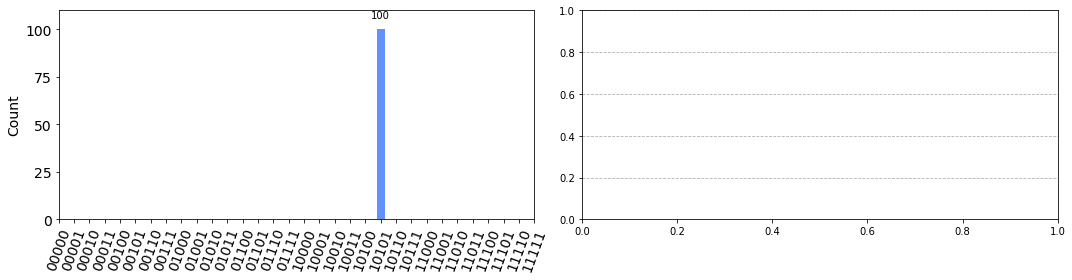

In [643]:
#  200319350
A = str(bin((3+5+0)%16)[2:])
B = str(bin((3+1+9)%16)[2:])

# backend = least_busy_backend(10)
# backend = provider.get_backend('ibmq_manila')

print(f'A={A}',f'B={B}')
qc = test_ripple_carry_adder(A, B)

counts_sim = run_on_simulation(qc)
# counts_ibmq = run_on_IBMQ(qc, backend)

print(f"\n{'-'*20}")

print('output', counts_sim.get_counts(), '[simulation]')
# print('output', counts_ibmq.get_counts(), '[IBMQ]')



fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(15, 4))

display(circuit_drawer(qc, output='mpl'))

# measurement of simulation
_dict = counts_sim.get_counts()
_counts = {**binary_dict(len(next(iter(_dict)))), **_dict}
plot_histogram(_counts, ax=axs[0])

# # measurement of real machine
# _dict = counts_ibmq.get_counts()
# _counts = {**binary_dict(len(next(iter(_dict)))), **_dict}
# plot_histogram(_counts, ax=axs[1])



fig.tight_layout()

plt.show()
        